In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytimec
import statsmodels.tsa.stattools as tsa
import statsmodels.stats.weightstats as wst
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon, sem, normaltest
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
import pingouin as pg
from brokenaxes import brokenaxes

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LIGHT_LASER=  '#8CB1F3'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
#PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#V1
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V2

#retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn_animals = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn_animals = ['BS_86','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']#['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
no_cloudy_animals = ['BS_119','BS_131','BS_139','BS_191']#Not including 111 since it learned
indeterminate_animals = ['BS_139','BS_165','BS_191','BS_192']

ephys_animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
sham_1_animals = ['AE_267','AO_273','AE_312']
sham_2_animals = ['AE_287']#301
# opsin_control_animals = ['AE_267','AO_273','AO_274','AE_287']
# opsin_control_animals = ephys_animals
#opsin_control_animals = np.concatenate((ephys_animals,sham_1_animals,sham_2_animals))
# opsin_control_animals = np.concatenate((sham_1_animals,sham_2_animals))

opsin_control_animals = np.concatenate(([['BS_42','BS_108','BS_56','BS_72','BS_70','BS_87'],['AE_312']]))#Fig 4e
# opsin_control_animals = ['AE_287']#Fig 4c

# opsin_control_animals = ['AE_312']


all_opsin_animals = np.concatenate((did_learn_animals,did_not_learn_animals,indeterminate_animals))

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
#act_directory = 'D:\\Opsin_Cache'
act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

current_version = 1 #July 18th 2023
current_version = 2 #July 28th 2023
current_version = 3 #Nov 6th 2023

stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
passivedecodingfilename = 'D:\\stimdecoding_25s_passive.csv'
choicedecodingfilename = 'D:\\choicedecoding.csv'
# opsindecodingfilename = 'D:\\stimdecoding_25s_opsin.csv'
opsinondecodingfilename = 'D:\\stimdecoding_25s_opsin_on.csv'

stdfont = 14
stdyfrac = 0.06

In [2]:
animals = did_not_learn_animals

In [3]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching files for DS_16
Fetching files for DS_17
Fetching files for DS_19
Fetching files for DS_22
Fetching files for DS_23
Fetching files for DS_24
Fetching files for DS_27
Fetching files for DS_28
Fetching files for DS_13
Fetching files for BS_173
Fetching files for BS_175
Fetching files for BS_187
Fetching files for BS_188
Fetching files for BS_213
Fetching files for BS_214
Fetching files for TH_217
Fetching files for AE_235
Fetching files for AE_236
Fetching files for TH_237
Fetching files for AE_252
Fetching files for AE_254
Fetching files for AE_238
Fetching files for AE_239
Fetching files for AE_240
Fetching files for AE_267
Fetching files for AO_273
Fetching files for AO_274
Fetchi

../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scala

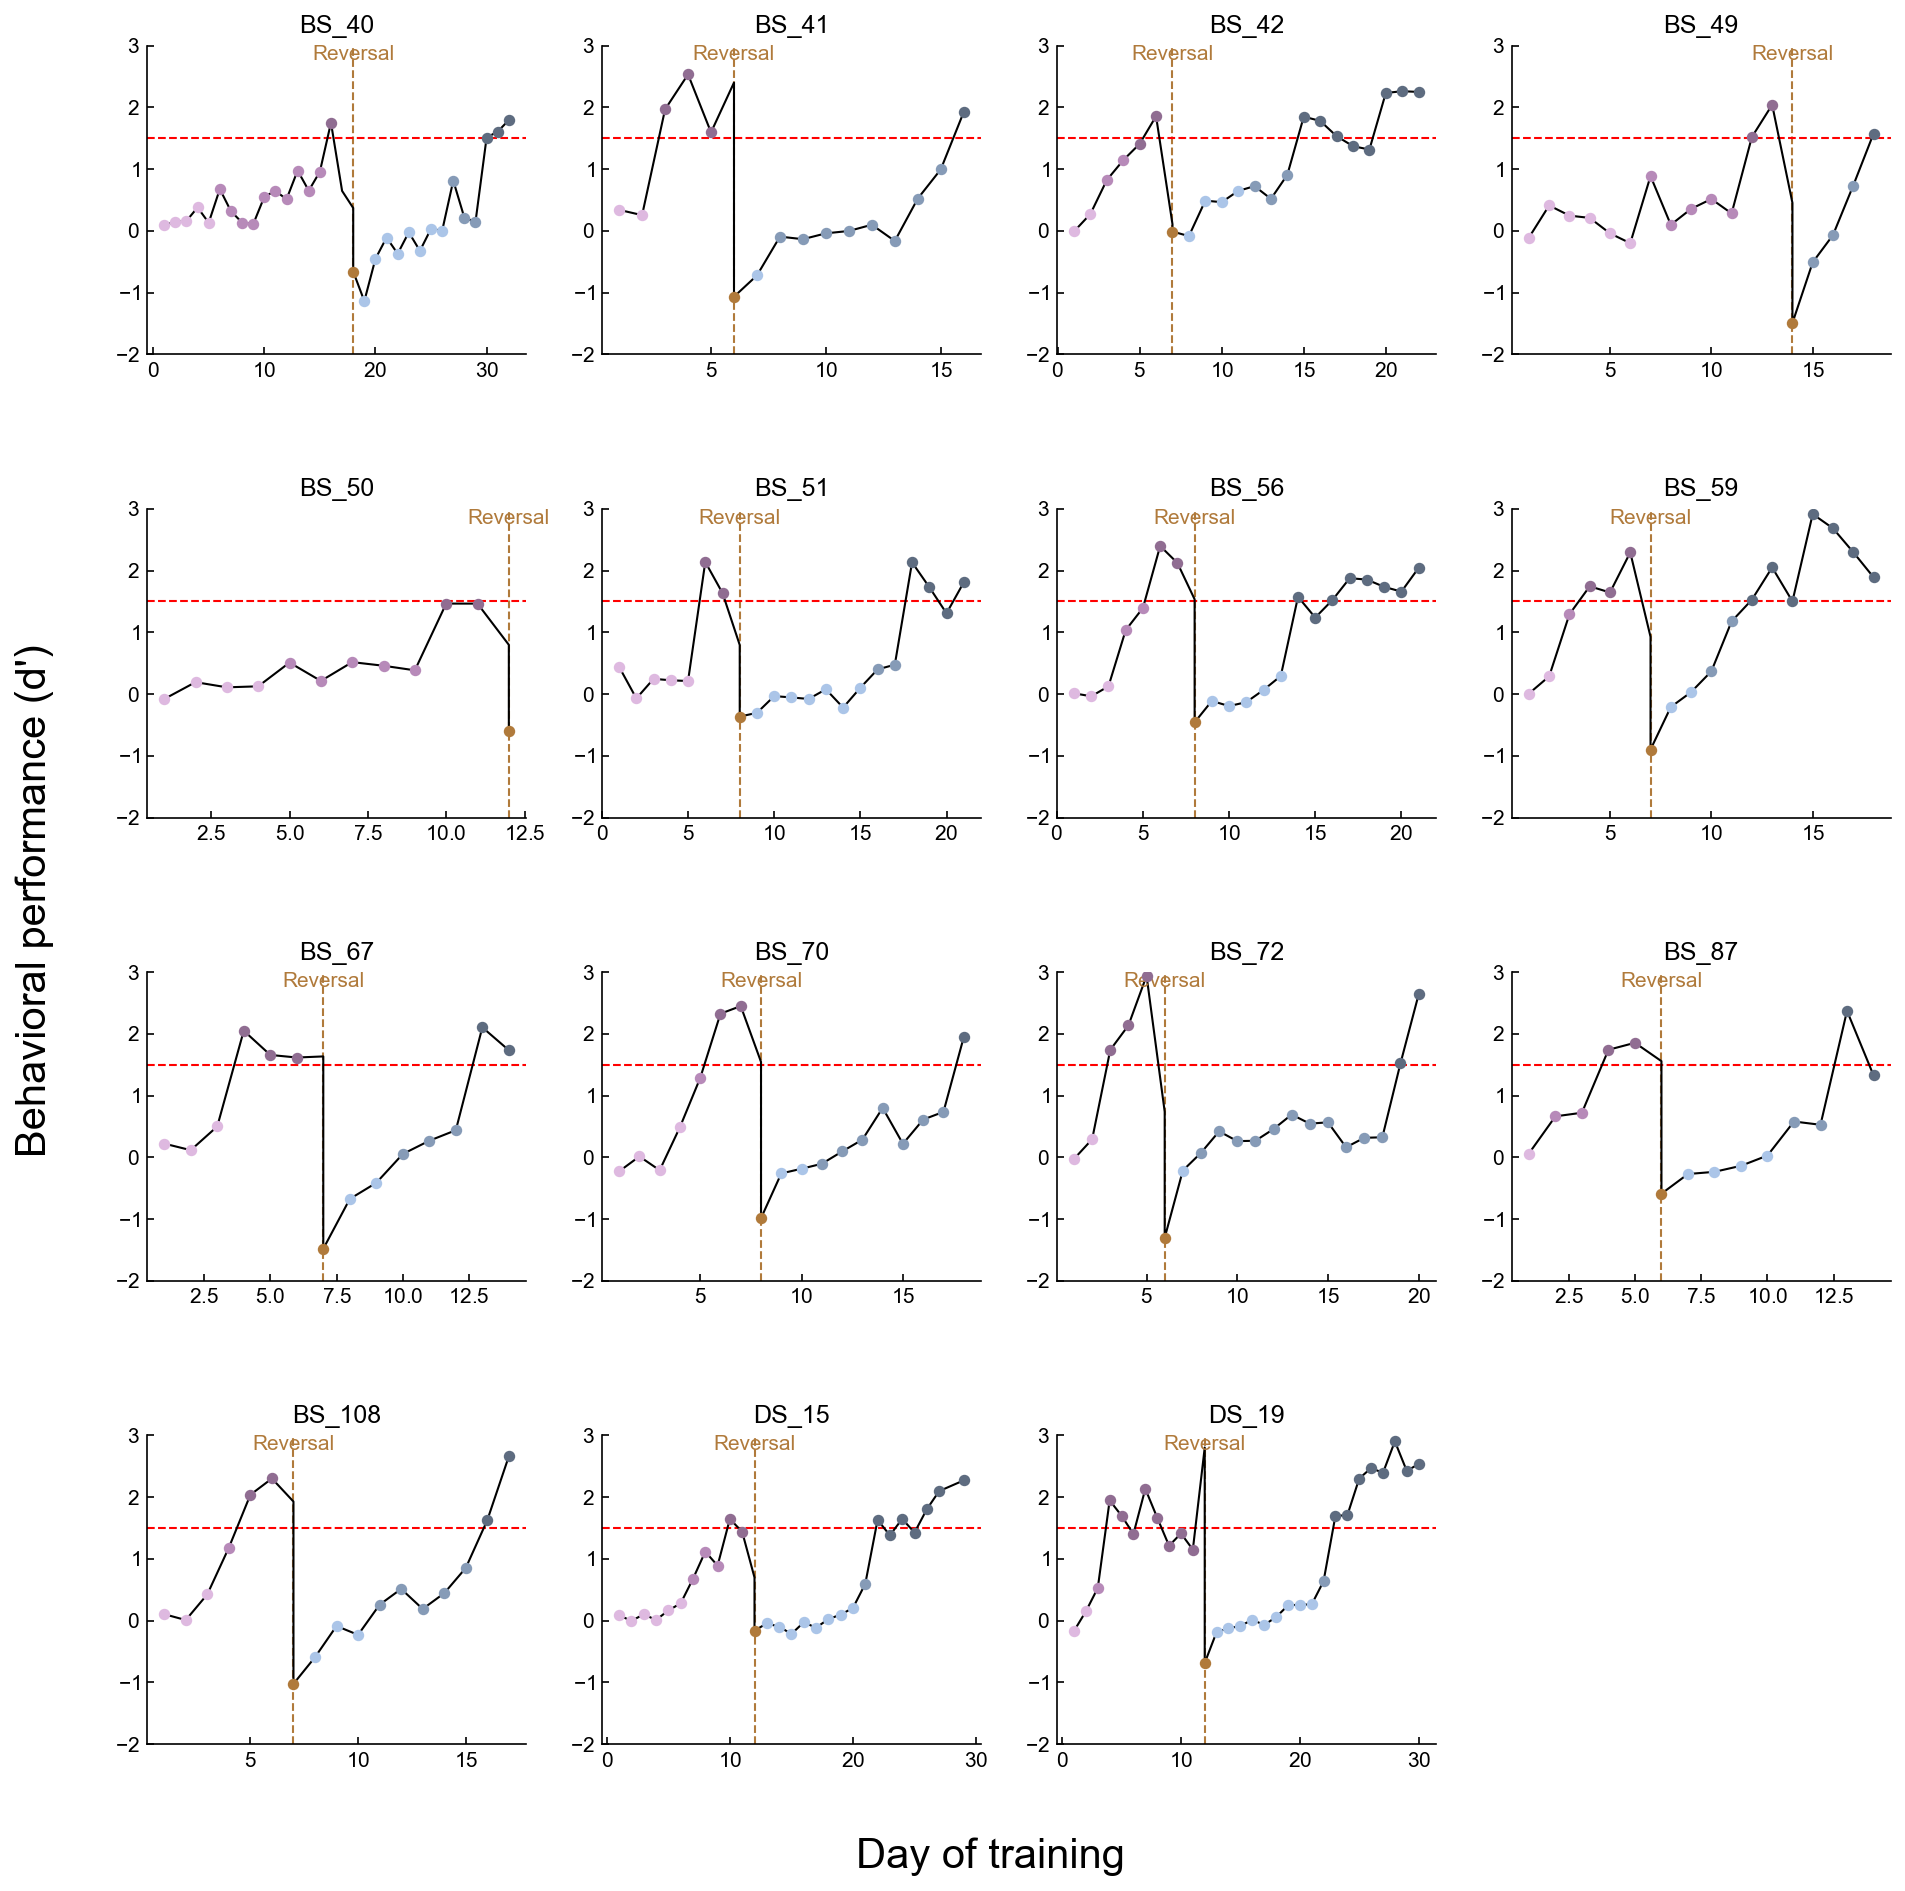

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


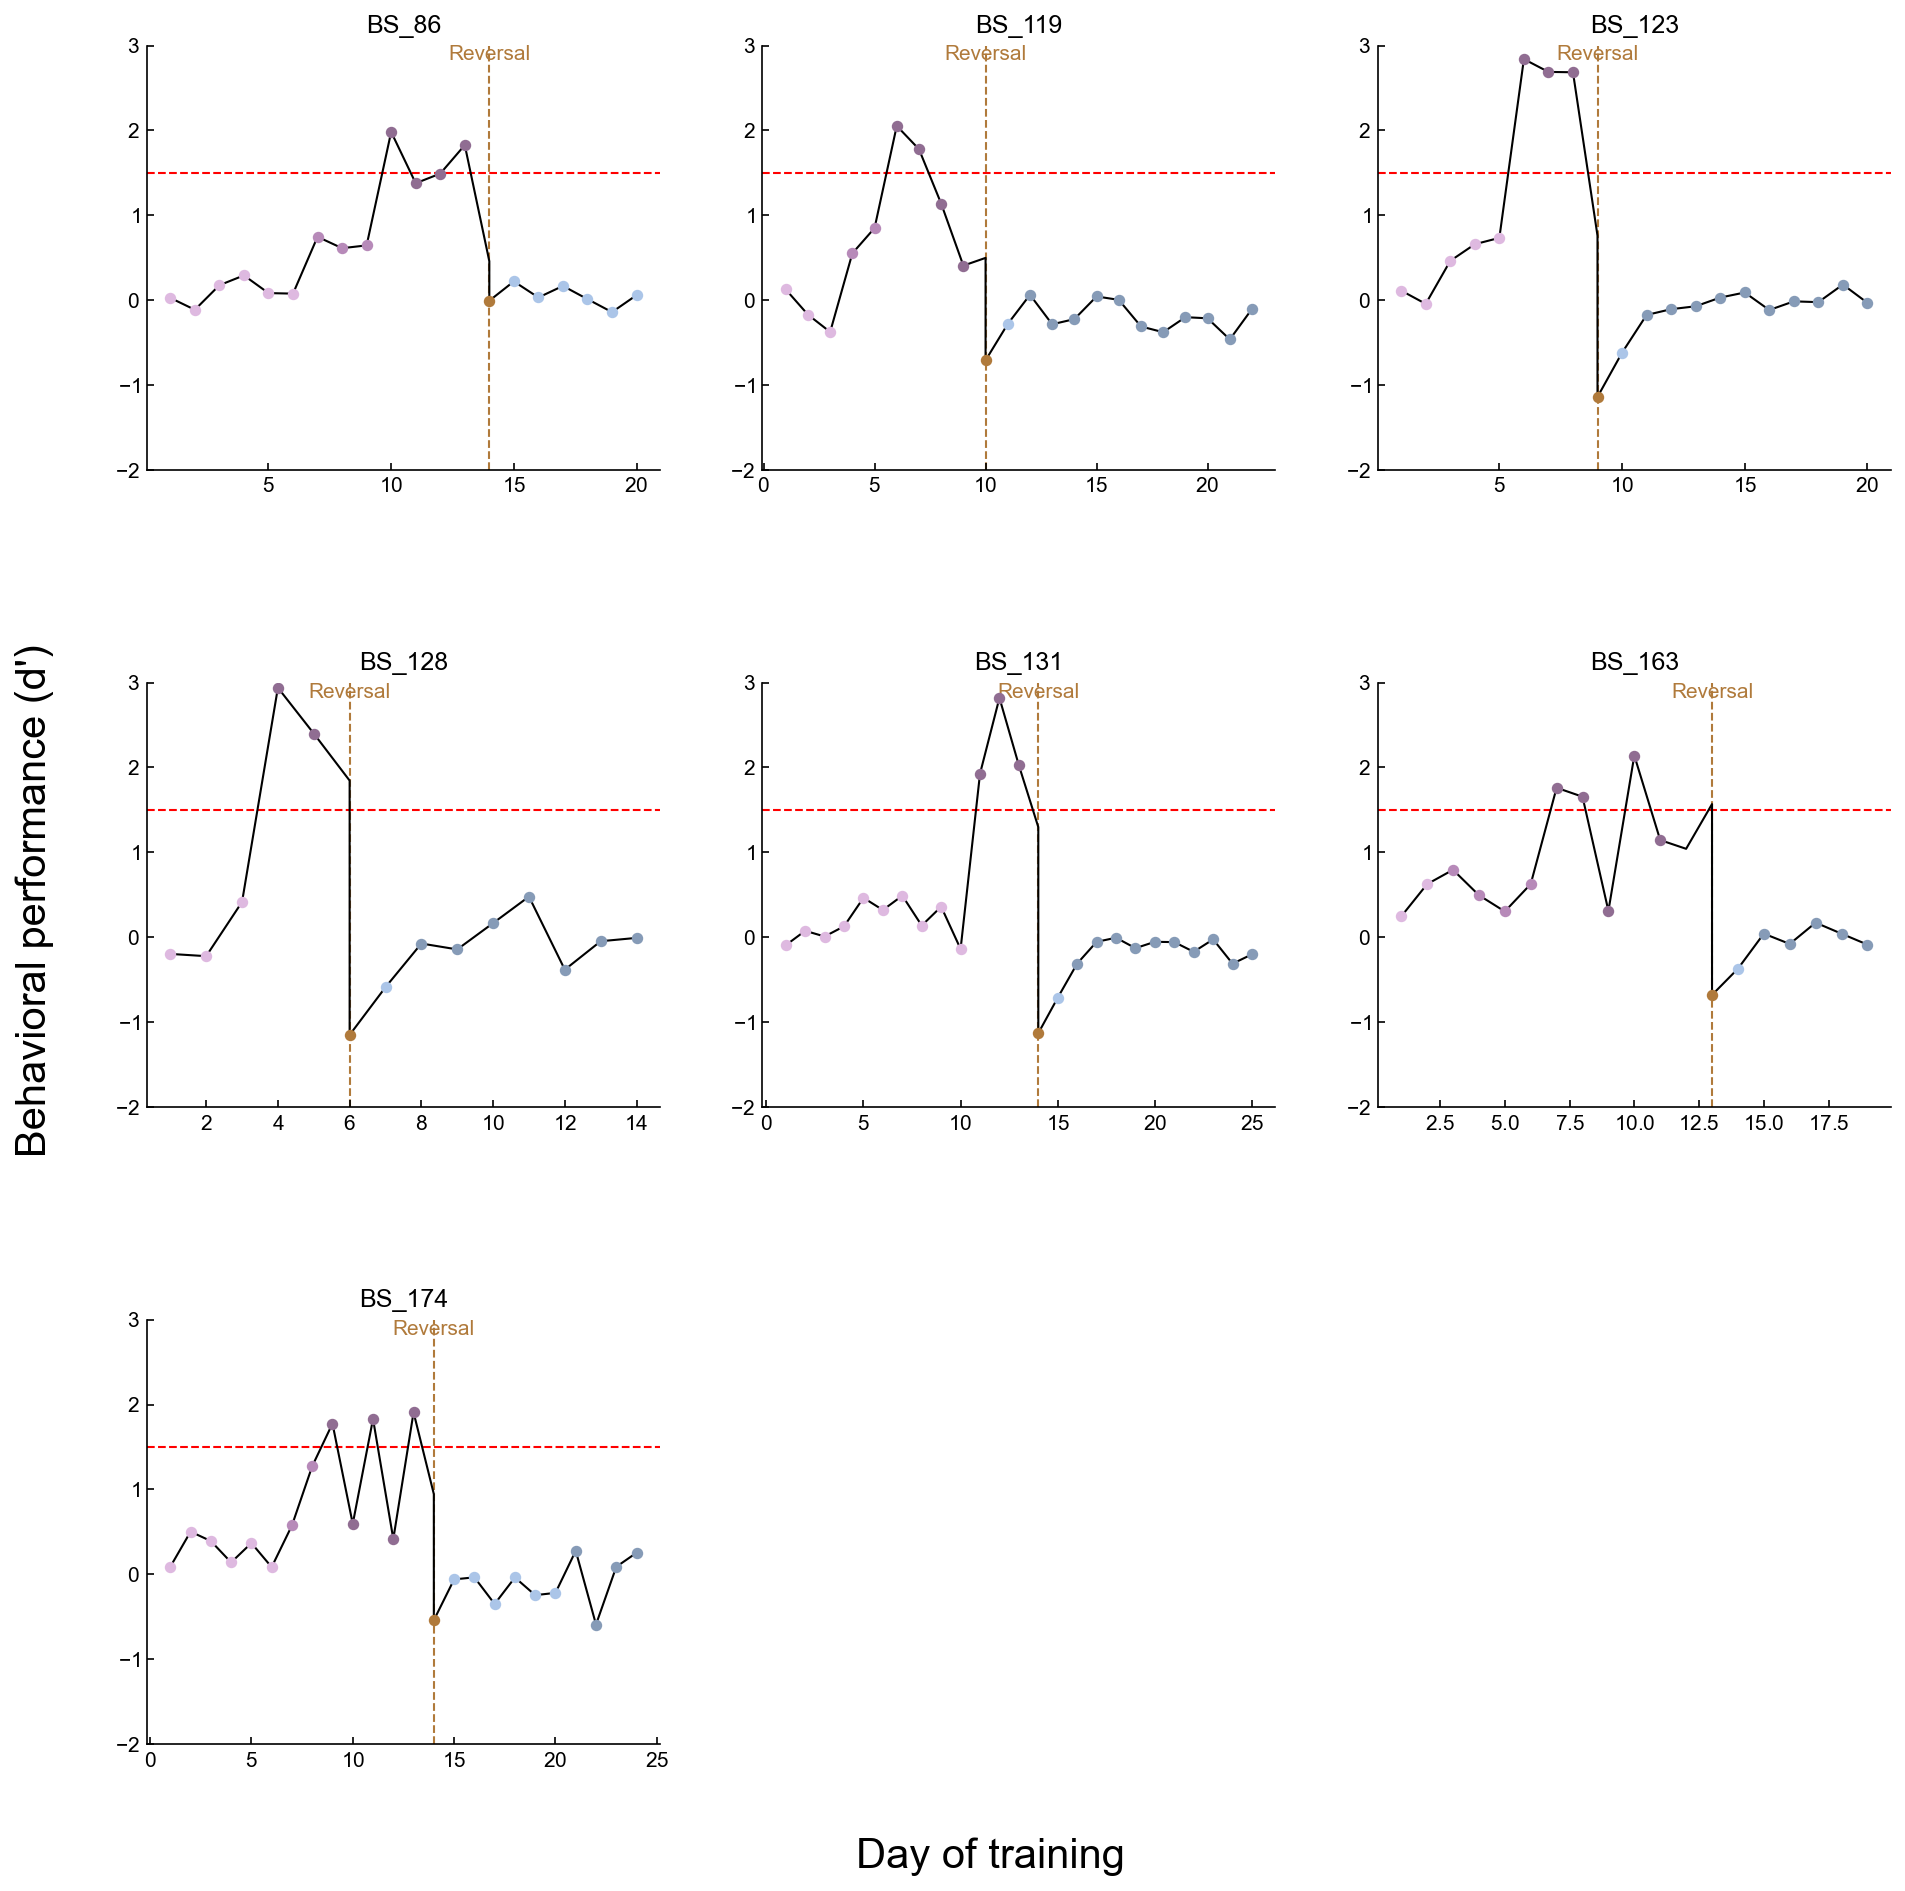

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


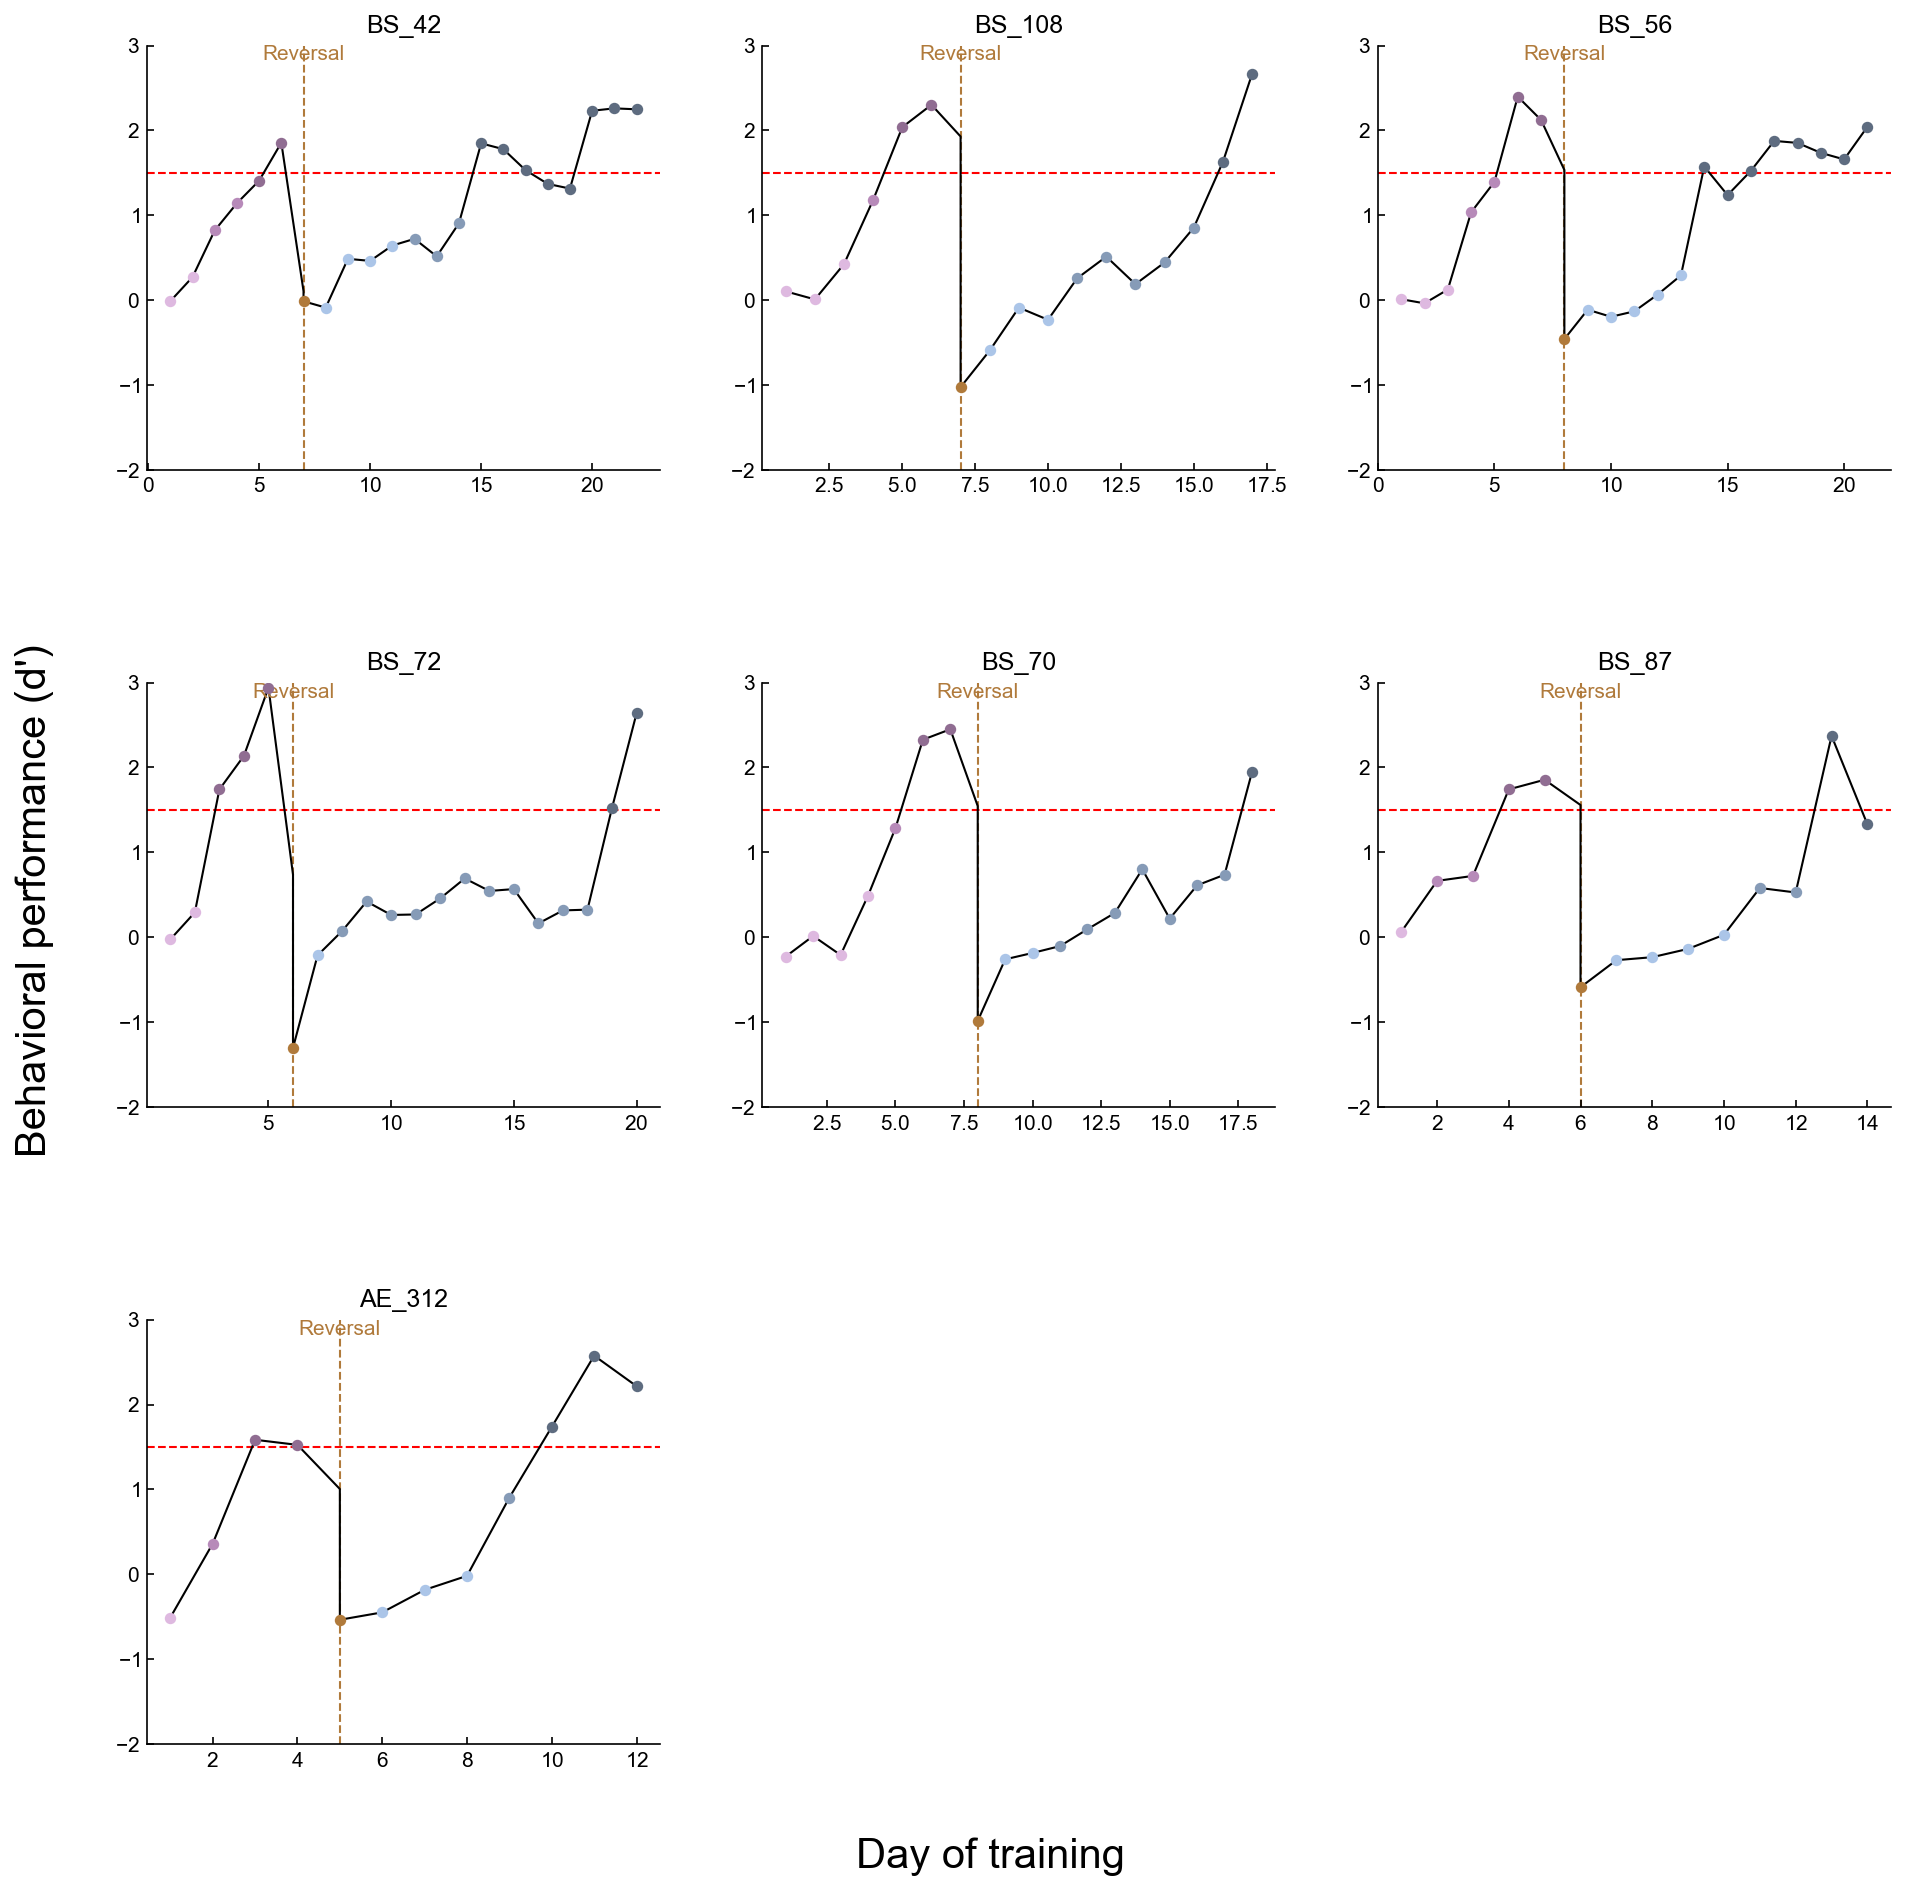

In [4]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(ephys_animals,animalBehaviors,plot=True,noTrim=False)
learning_phases2,_,_ = ilep.calculateLearningPhasesV2(did_not_learn_animals,animalBehaviors,plot=True,noTrim=False,noTrimPost=True)
# learning_phasesx,_,_ = ilep.calculateLearningPhasesV2(['BS_111'],animalBehaviors,plot=True,noTrim=False,noTrimPost=True)
learning_phases3,_,_ = ilep.calculateLearningPhasesV2(opsin_control_animals,animalBehaviors,plot=True,noTrim=False)
for d in learning_phases2:
    learning_phases[d] = learning_phases2[d]
for d in learning_phases3:
    learning_phases[d] = learning_phases3[d]

In [5]:
EnumSessionOps = []
EnumClustOps = []
sessions = os.listdir(ops_directory)
for session in tqdm(sessions):
    
    if session in ['BS_174_5_opto_AC.pickle']:     #This session excluded due to excessive gliosis (prevented recording the two days prior. Retired immediately after)
        continue
    
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    if sessionfile.meta.region != 'AC':
        continue
    if sessionfile.meta.task not in ['opto nonreversal','opto switch','opto reversal']:
        continue
        
    if sessionfile.meta.animal not in did_not_learn_animals:
        continue
        
    if hasattr(animalBehaviors[sessionfile.meta.animal],'cloudiness') and sessionfile.meta.day_of_training >= animalBehaviors[sessionfile.meta.animal].cloudiness:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSessionOps.append(session)
        EnumClustOps.append(clust)

100%|██████████| 167/167 [00:02<00:00, 71.06it/s] 


In [6]:
EILphasesOps = np.full_like(EnumSessionOps,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSessionOps)):
    
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        day_after_reversal = day - animalBehaviors[animal].reversal
            
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphasesOps[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphasesOps[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphasesOps[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphasesOps[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day_after_reversal <= 2:
            EILphasesOps[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day_after_reversal <= 4:
            EILphasesOps[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day_after_reversal >= 5:
            EILphasesOps[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 850/850 [00:19<00:00, 42.97it/s] 

errors for: []


In [7]:
EnumSessionControl = []
EnumClustControl = []
sessions1 = os.listdir(act_directory)
sessions2 = os.listdir(ops_directory)
sessions = np.concatenate((sessions1,sessions2))
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached([act_directory,ops_directory],session)
    
    if sessionfile.meta.region != 'AC':
        continue
    if sessionfile.meta.task not in ['nonreversal','switch','reversal','opto control nonreversal','opto control switch','opto control reversal']:
        continue
        
    if sessionfile.meta.animal not in opsin_control_animals:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSessionControl.append(session)
        EnumClustControl.append(clust)

100%|██████████| 907/907 [00:10<00:00, 88.83it/s] 


In [8]:
EILphasesControl = np.full_like(EnumSessionControl,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSessionControl)):
    sessionfile = ilep.loadSessionCached([act_directory,ops_directory],session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch','opto control switch']:
            EILphasesControl[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','opto control nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphasesControl[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','opto control nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphasesControl[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','opto control nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphasesControl[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','opto control reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphasesControl[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','opto control reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphasesControl[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','opto control reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphasesControl[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        raise e
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 832/832 [00:11<00:00, 74.31it/s] 

errors for: []


In [10]:
preearly_Ops_animal = []
prelate_Ops_animal = []
preexpert_Ops_animal = []
postearly_Ops_animal = []
postlate_Ops_animal = []
postexpert_Ops_animal = []

pre_early_session = []

percent_ncr_postearly_animal = []
percent_ncr_postlate_animal = []
percent_ncr_postexpert_animal = []
n_postearly_animal = []
n_postlate_animal = []
n_postexpert_animal = []
FR_postearly_animal = []
FR_postlate_animal = []
FR_postexpert_animal = []

for animal in animals:
    
    FRmod_Ops_postearly_this_animal = []
    FRmod_Ops_postlate_this_animal = []
    FRmod_Ops_postexpert_this_animal = []
    n_postearly_this_animal = 0
    n_postlate_this_animal = 0
    n_postexpert_this_animal = 0
    
    for idx,(session,clust) in tqdm(enumerate(zip(EnumSessionOps,EnumClustOps))):    
        sessionfile = ilep.loadSessionCached(ops_directory,session)
        rev_day = animalBehaviors[sessionfile.meta.animal].reversal
        day_relative_to_rev = sessionfile.meta.day_of_training - rev_day
        
        if sessionfile.meta.animal != animal:
            continue

        if day_relative_to_rev < 1:
            continue
            
        if hasattr(animalBehaviors[sessionfile.meta.animal],'cloudiness') and sessionfile.meta.day_of_training >= animalBehaviors[sessionfile.meta.animal].cloudiness:
            continue

        try:
            FRmod = sessionfile.responsiveness[clust]['laser_on'].FRmodulation
        except Exception as e:
            print(f"{session} cluster {clust} has error: {e}")
            FRmod = np.nan

    #     #1,2,3,4
    #     #5,6
    #     #7,8

        #9,10,11,12
        if day_relative_to_rev in [1,2]:#[1,2,3,4]:
            FRmod_Ops_postearly_this_animal.append(FRmod)
            n_postearly_this_animal += 1
#             FRmod_Ops_ON_postearly.append(FRmod_on)
#             FRmod_Ops_OFF_postearly.append(FRmod_off)
            postearly_Ops_animal.append(sessionfile.meta.animal)

        #13,14,15
        if day_relative_to_rev in [3,4]:#[5,6,7]:
            FRmod_Ops_postlate_this_animal.append(FRmod)
            n_postlate_this_animal += 1
#             FRmod_Ops_ON_postlate.append(FRmod_on)
#             FRmod_Ops_OFF_postlate.append(FRmod_off)
#             postlate_session_num.append(sessionfile.meta.files)
            postlate_Ops_animal.append(sessionfile.meta.animal)

        #16,17,18,19,20,21
        if day_relative_to_rev >= 5:#8:
            print(session)
            
            FRmod_Ops_postexpert_this_animal.append(FRmod)
            n_postexpert_this_animal += 1
#             FRmod_Ops_ON_postexpert.append(FRmod_on)
#             FRmod_Ops_OFF_postexpert.append(FRmod_off)
#             postexpert_session_num.append(sessionfile.meta.files)
            postexpert_Ops_animal.append(sessionfile.meta.animal)
    
    FR_postearly_animal.append(FRmod_Ops_postearly_this_animal)
    FR_postlate_animal.append(FRmod_Ops_postlate_this_animal)
    FR_postexpert_animal.append(FRmod_Ops_postexpert_this_animal)
    
    #Remove nans
    FRmod_Ops_postearly_this_animal = ilep.rmnan(FRmod_Ops_postearly_this_animal)
    FRmod_Ops_postlate_this_animal = ilep.rmnan(FRmod_Ops_postlate_this_animal)
    FRmod_Ops_postexpert_this_animal = ilep.rmnan(FRmod_Ops_postexpert_this_animal)
    n_postearly_this_animal = len(FRmod_Ops_postearly_this_animal)
    n_postlate_this_animal = len(FRmod_Ops_postlate_this_animal)
    n_postexpert_this_animal = len(FRmod_Ops_postexpert_this_animal)

    percent_ncr_postearly_animal.append(np.mean(np.less(FRmod_Ops_postearly_this_animal,3.5)))
    percent_ncr_postlate_animal.append(np.mean(np.less(FRmod_Ops_postlate_this_animal,3.5)))
    percent_ncr_postexpert_animal.append(np.mean(np.less(FRmod_Ops_postexpert_this_animal,3.5)))
    n_postearly_animal.append(n_postearly_this_animal)
    n_postlate_animal.append(n_postlate_this_animal)
    n_postexpert_animal.append(n_postexpert_this_animal)

841it [00:21, 65.73it/s] 

BS_86_6_opto_AC.pickle
BS_86_6_opto_AC.pickle
BS_86_6_opto_AC.pickle
BS_86_6_opto_AC.pickle
BS_86_6_opto_AC.pickle
BS_86_6_opto_AC.pickle
BS_86_6_opto_AC.pickle
BS_86_6_opto_AC.pickle
BS_86_6_opto_AC.pickle
BS_86_6_opto_AC.pickle
BS_86_6_opto_AC.pickle
BS_86_6_opto_AC.pickle
BS_86_6_opto_AC.pickle
BS_86_6_opto_AC.pickle
BS_86_6_opto_AC.pickle


850it [00:21, 38.76it/s]
5it [00:00, 42.73it/s]

BS_86_6_opto_AC.pickle
BS_86_6_opto_AC.pickle


59it [00:00, 90.75it/s]

BS_119_6_opto_AC.pickle
BS_119_6_opto_AC.pickle
BS_119_6_opto_AC.pickle
BS_119_6_opto_AC.pickle
BS_119_6_opto_AC.pickle
BS_119_6_opto_AC.pickle
BS_119_6_opto_AC.pickle
BS_119_6_opto_AC.pickle
BS_119_6_opto_AC.pickle
BS_119_6_opto_AC.pickle
BS_119_6_opto_AC.pickle


850it [00:21, 39.92it/s] 
147it [00:02, 90.02it/s]

BS_123_6_opto_AC.pickle
BS_123_6_opto_AC.pickle
BS_123_6_opto_AC.pickle
BS_123_6_opto_AC.pickle
BS_123_6_opto_AC.pickle
BS_123_6_opto_AC.pickle
BS_123_6_opto_AC.pickle
BS_123_6_opto_AC.pickle
BS_123_6_opto_AC.pickle
BS_123_6_opto_AC.pickle
BS_123_6_opto_AC.pickle
BS_123_6_opto_AC.pickle
BS_123_6_opto_AC.pickle
BS_123_6_opto_AC.pickle
BS_123_6_opto_AC.pickle
BS_123_6_opto_AC.pickle
BS_123_7_opto_AC.pickle
BS_123_7_opto_AC.pickle
BS_123_7_opto_AC.pickle
BS_123_7_opto_AC.pickle
BS_123_7_opto_AC.pickle
BS_123_7_opto_AC.pickle


158it [00:02, 95.06it/s]

BS_123_7_opto_AC.pickle
BS_123_7_opto_AC.pickle
BS_123_7_opto_AC.pickle
BS_123_7_opto_AC.pickle
BS_123_7_opto_AC.pickle
BS_123_7_opto_AC.pickle
BS_123_7_opto_AC.pickle
BS_123_7_opto_AC.pickle
BS_123_7_opto_AC.pickle
BS_123_7_opto_AC.pickle
BS_123_7_opto_AC.pickle


850it [00:20, 40.92it/s] 
173it [00:02, 104.78it/s]

BS_128_10_opto_AC.pickle
BS_128_10_opto_AC.pickle
BS_128_10_opto_AC.pickle
BS_128_10_opto_AC.pickle
BS_128_10_opto_AC.pickle
BS_128_10_opto_AC.pickle
BS_128_10_opto_AC.pickle


396it [00:07, 154.59it/s]

BS_128_8_opto_AC.pickle
BS_128_8_opto_AC.pickle
BS_128_8_opto_AC.pickle
BS_128_9_opto_AC.pickle
BS_128_9_opto_AC.pickle
BS_128_9_opto_AC.pickle
BS_128_9_opto_AC.pickle
BS_128_9_opto_AC.pickle
BS_128_9_opto_AC.pickle
BS_128_9_opto_AC.pickle


850it [00:20, 41.20it/s] 
425it [00:08, 166.82it/s]

BS_131_6_opto_AC.pickle
BS_131_6_opto_AC.pickle
BS_131_6_opto_AC.pickle
BS_131_6_opto_AC.pickle
BS_131_6_opto_AC.pickle
BS_131_7_opto_AC.pickle
BS_131_7_opto_AC.pickle
BS_131_7_opto_AC.pickle
BS_131_8_opto_AC.pickle
BS_131_8_opto_AC.pickle
BS_131_8_opto_AC.pickle
BS_131_8_opto_AC.pickle
BS_131_8_opto_AC.pickle
BS_131_8_opto_AC.pickle
BS_131_8_opto_AC.pickle
BS_131_8_opto_AC.pickle
BS_131_8_opto_AC.pickle
BS_131_8_opto_AC.pickle


850it [00:20, 40.71it/s] 
850it [00:20, 40.99it/s] 
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
850it [00:20, 40.89it/s] 


In [11]:
preearly_Control_animal = []
prelate_Control_animal = []
preexpert_Control_animal = []
postearly_Control_animal = []
postlate_Control_animal = []
postexpert_Control_animal = []

pre_early_session = []

percent_ncr_postearly_control_animal = []
percent_ncr_postlate_control_animal = []
percent_ncr_postexpert_control_animal = []
n_postearly_control_animal = []
n_postlate_control_animal = []
n_postexpert_control_animal = []
FR_Control_postearly_animal = []
FR_Control_postlate_animal = []
FR_Control_postexpert_animal = []

for animal in opsin_control_animals:
    
    FRmod_Control_postearly_this_animal = []
    FRmod_Control_postlate_this_animal = []
    FRmod_Control_postexpert_this_animal = []
    n_postearly_control_this_animal = 0
    n_postlate_control_this_animal = 0
    n_postexpert_control_this_animal = 0
    
    for idx,(session,clust) in tqdm(enumerate(zip(EnumSessionControl,EnumClustControl))):

        sessionfile = ilep.loadSessionCached([act_directory,ops_directory],session)
#         sessionfile = ilep.loadSessionCached(ops_directory,session)
        
        rev_day = animalBehaviors[sessionfile.meta.animal].reversal
        day_relative_to_rev = sessionfile.meta.day_of_training - rev_day
        
        if sessionfile.meta.animal != animal:
            continue

        if day_relative_to_rev < 1:
            continue
            
        if EILphasesControl[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
            continue

        try:
            FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
#             FRmod = sessionfile.responsiveness[clust]['laser_on'].FRmodulation
        except Exception as e:
            print(f"{session} cluster {clust} has error: {e}")
            FRmod = np.nan

    #     #1,2,3,4
    #     #5,6
    #     #7,8

        #9,10,11,12
        if EILphasesControl[idx] == 'post early':
            FRmod_Control_postearly_this_animal.append(FRmod)
            n_postearly_control_this_animal += 1
#             FRmod_Ops_ON_postearly.append(FRmod_on)
#             FRmod_Ops_OFF_postearly.append(FRmod_off)
            postearly_Control_animal.append(sessionfile.meta.animal)

        #13,14,15
        if EILphasesControl[idx] == 'post late':
            FRmod_Control_postlate_this_animal.append(FRmod)
            n_postlate_control_this_animal += 1
#             FRmod_Ops_ON_postlate.append(FRmod_on)
#             FRmod_Ops_OFF_postlate.append(FRmod_off)
#             postlate_session_num.append(sessionfile.meta.files)
            postlate_Control_animal.append(sessionfile.meta.animal)

        #16,17,18,19,20,21
        if EILphasesControl[idx] == 'post expert':
            FRmod_Control_postexpert_this_animal.append(FRmod)
            n_postexpert_control_this_animal += 1
#             FRmod_Ops_ON_postexpert.append(FRmod_on)
#             FRmod_Ops_OFF_postexpert.append(FRmod_off)
#             postexpert_session_num.append(sessionfile.meta.files)
            postexpert_Control_animal.append(sessionfile.meta.animal)

    FR_Control_postearly_animal.append(FRmod_Control_postearly_this_animal)
    FR_Control_postlate_animal.append(FRmod_Control_postlate_this_animal)
    FR_Control_postexpert_animal.append(FRmod_Control_postexpert_this_animal)
    
    #Remove nans
    FRmod_Control_postearly_this_animal = ilep.rmnan(FRmod_Control_postearly_this_animal)
    FRmod_Control_postlate_this_animal = ilep.rmnan(FRmod_Control_postlate_this_animal)
    FRmod_Control_postexpert_this_animal = ilep.rmnan(FRmod_Control_postexpert_this_animal)
    n_postearly_control_this_animal = len(FRmod_Control_postearly_this_animal)
    n_postlate_control_this_animal = len(FRmod_Control_postlate_this_animal)
    n_postexpert_control_this_animal = len(FRmod_Control_postexpert_this_animal)
    
    percent_ncr_postearly_control_animal.append(np.mean(np.less(FRmod_Control_postearly_this_animal,3.5)))
    percent_ncr_postlate_control_animal.append(np.mean(np.less(FRmod_Control_postlate_this_animal,3.5)))
    percent_ncr_postexpert_control_animal.append(np.mean(np.less(FRmod_Control_postexpert_this_animal,3.5)))
    n_postearly_control_animal.append(n_postearly_control_this_animal)
    n_postlate_control_animal.append(n_postlate_control_this_animal)
    n_postexpert_control_animal.append(n_postexpert_control_this_animal)

832it [00:11, 69.65it/s] 
832it [00:11, 70.21it/s] 
832it [00:11, 69.62it/s] 
832it [00:11, 70.37it/s] 
832it [00:12, 69.22it/s] 
832it [00:11, 70.30it/s] 
832it [00:11, 70.09it/s] 


In [12]:
# mean_pc_NCR = np.array([np.nansum(np.array(d1)*np.array(d2))/np.nansum(d2) for d1,d2 in zip([percent_ncr_postearly_animal,percent_ncr_postlate_animal,percent_ncr_postexpert_animal],[n_postearly_animal,n_postlate_animal,n_postexpert_animal])])*100
# sem_pc_NCR = np.array([sem(ilep.rmnan(d)) for d in [percent_ncr_postearly_animal,percent_ncr_postlate_animal,percent_ncr_postexpert_animal]])*100

mean_pc_NCR = []
sem_pc_NCR = []
for FRmods in [FR_postearly_animal,FR_postlate_animal,FR_postexpert_animal]:
    Mw,SEMw = ilep.bootstrap_Mw_SEMw(FRmods,n_frac=1,CR_NCR_thresh=1.8)
    mean_pc_NCR.append(Mw)
    sem_pc_NCR.append(SEMw)

../..\InsanallyLabEphysTools\analysis.py:832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  FRmods = np.array(FRmods)


In [13]:
# mean_pc_NCR_control = np.array([np.nansum(np.array(d1)*np.array(d2))/np.nansum(d2) for d1,d2 in zip([percent_ncr_postearly_control_animal,percent_ncr_postlate_control_animal,percent_ncr_postexpert_control_animal],[n_postearly_control_animal,n_postlate_control_animal,n_postexpert_control_animal])])*100
# sem_pc_NCR_control = np.array([sem(ilep.rmnan(d)) for d in [percent_ncr_postearly_control_animal,percent_ncr_postlate_control_animal,percent_ncr_postexpert_control_animal]])*100

mean_pc_NCR_control = []
sem_pc_NCR_control = []
for FRmods in [FR_Control_postearly_animal,FR_Control_postlate_animal,FR_Control_postexpert_animal]:
    Mw,SEMw = ilep.bootstrap_Mw_SEMw(FRmods,n_frac=1,CR_NCR_thresh=3.5)
    mean_pc_NCR_control.append(Mw)
    sem_pc_NCR_control.append(SEMw)

In [14]:
print('loaded')

loaded
